Steady-state convection-diffusion equation
\begin{align*}
        -\nu \Delta u + {\bf \beta} \cdot \nabla u + \alpha u&= f, \quad \text{in } \Omega \\
u&=u^b \quad \text{on } \Gamma_D 
\end{align*}

$$
        \nu (\nabla u, \nabla v) + ({\bf \beta}\cdot \nabla u, v) + \alpha(u,v)= (f,v)\\
        \nu \left(\frac{\partial u}{\partial x},\frac{\partial u}{\partial x}\right) 
$$

In [1]:
using LinearAlgebra
using GradientRobustMultiPhysics
using ExtendableGrids
using GridVisualize
using ExtendableSparse
using SparseArrays

Consider the smooth solution 
$$
u(x,y) := xy(x-1)(y-1) + x
$$

In [3]:
function get_problem_data(ν)
    α = DataFunction([0.1]; name = "α")
    β = DataFunction([1, 0]; name = "β")
    function exact_u!(result,x)
        result[1] = x[1]*x[2]*(x[1]-1)*(x[2]-1) + x[1]
    end
    u = DataFunction(exact_u!, [1,2]; name = "u", dependencies = "X", bonus_quadorder = 4)
    ∇u = eval_∇(u) # handler for easy eval of AD jacobian
    Δu = eval_Δ(u) # handler for easy eval of AD Laplacian
    function rhs!(result, x) # computes -νΔu + β⋅∇u + αu
        result[1] = -ν*Δu(x)[1] + dot(β(), ∇u(x)) + dot(α(), u(x))
        return nothing
    end    
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "X", bonus_quadorder = 3)
    return α, β, u, ∇(u), f
end

get_problem_data (generic function with 1 method)

In [4]:
## custom bilinearform that can assemble the full PDE operator
function ReactionConvectionDiffusionOperator(α, β, ν)
    function action_kernel!(result, input)
        ## input = [u,∇u] as a vector of length 3
        result[1] = α()[1] * input[1] + dot(β(), view(input, 2:3))
        result[2] = ν * input[2]
        result[3] = ν * input[3]
        ## result will be multiplied with [v,∇v]
        return nothing
    end
    action = Action(action_kernel!, [3,3]; bonus_quadorder = max(α.bonus_quadorder,β.bonus_quadorder))
    return BilinearForm([OperatorPair{Identity,Gradient},OperatorPair{Identity,Gradient}], action; 
        name = "ν(∇u,∇v) + (αu + β⋅∇u, v)", transposed_assembly = true)
end

ReactionConvectionDiffusionOperator (generic function with 1 method)

In [5]:
function run_main(; ν=1e-5, nlevels=3)
    # load initial mesh
    xgrid = grid_unitsquare(Triangle2D)
    # problem data
    α, β, u, ∇u, f = get_problem_data(ν)
    FEType = H1Pk{1,2,1}
    
    xgrid = uniform_refine(xgrid, nlevels)
    FES = FESpace{FEType}(xgrid)
    # solution vector
    Solution = FEVector("u_h", FES)
    
    dt = Array{BoundaryData,1}(undef,0)
    push!(dt,BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data=u))
    dofs = boundarydata!(Solution[1], dt)
    
    ## stiffness matrix
    A = FEMatrix{Float64}(FES)
    assemble_operator!(A[1,1], ReactionConvectionDiffusionOperator(α, β, ν))
    # @show A.entries
    rhs = FEVector{Float64}(FES)
    assemble_operator!(rhs[1], LinearForm(Identity, f))    
    
    # setting dirichlet dofs
    for dof in dofs
        rhs[1][dof] = 1e60 * Solution[1][dof]
        A[1,1][dof,dof] = 1e60
    end
    
    flush!(A.entries)
    Solution.entries[:] = A.entries \ rhs.entries
    # solve!(Solution, Problem)
    
    L2Error = L2ErrorIntegrator(u, Identity)
    H1Error = L2ErrorIntegrator(∇u, Gradient)    
    L2 = sqrt(evaluate(L2Error,Solution[1]))
    H1 = sqrt(evaluate(H1Error,Solution[1]))
    println("L2: ", L2, " H1 ", H1)
    println("done: ", FES.ndofs)
    (L2, H1)
end

run_main (generic function with 1 method)

In [6]:
function convergence_test(ns)
    H1=[]; L2=[]
    for n = 1 : ns
        l2, h1 = run_main(ν=1e-0, nlevels=n)
        push!(H1, h1)
        push!(L2, l2)
    end
    (L2, H1)
end

L2, H1 = convergence_test(4)

L2: 0.0059754493250941945 H1 0.05890611590514802
done: 13

┌ Warning:  21830550 allocations during ITEMTYPE_BFACE volume calculation
└ @ ExtendableGrids C:\Users\LENOVO\.julia\packages\ExtendableGrids\XFxI3\src\derived.jl:937



L2: 0.001680689116768702 H1 0.03173848374231691
done: 41
L2: 0.00043668119143605404 H1 0.01621387682749804
done: 145
L2: 0.00011063873110432883 H1 0.008158844428256698
done: 545


(Any[0.0059754493250941945, 0.001680689116768702, 0.00043668119143605404, 0.00011063873110432883], Any[0.05890611590514802, 0.03173848374231691, 0.01621387682749804, 0.008158844428256698])

L2uAny[0.0059754493250941945, 0.001680689116768702, 0.00043668119143605404, 0.00011063873110432883]
L2pAny[0.05890611590514802, 0.03173848374231691, 0.01621387682749804, 0.008158844428256698]


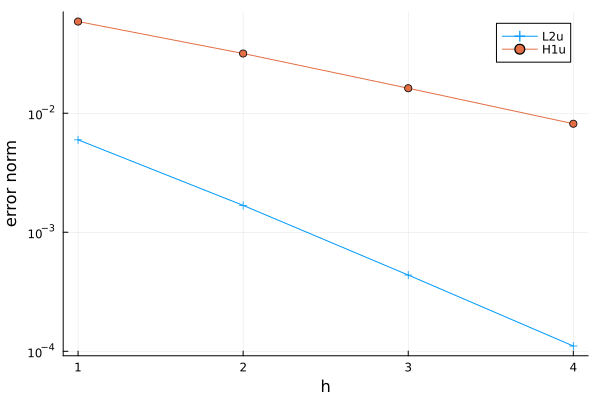

In [7]:
using Plots
println("L2u", L2)
println("L2p", H1)
taus = [1, 2, 3, 4]
plot(taus,[L2 H1],
    yaxis=:log10,
    label=["L2u" "H1u"],
    shape=:auto,
    xlabel="h",ylabel="error norm")

In [14]:
println("L2-Error is of 2nd order")
println(log2(0.0059754493250941945/0.001680689116768702))
println(log2(0.001680689116768702/0.00043668119143605404))
println(log2(0.00043668119143605404/0.00011063873110432883))

L2-Error is of 2nd order
1.82999431225325
1.9444005902937807
1.980723877565216
